In [1]:

import torch
print("✅ PyTorch version:", torch.__version__)
print("🚀 CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🎯 GPU Device Name:", torch.cuda.get_device_name(0))


✅ PyTorch version: 2.6.0+cu118
🚀 CUDA available: True
🎯 GPU Device Name: NVIDIA GeForce RTX 3060


In [2]:
import h5py
import os

root_dir = 'D:/SingalProject/OFDM Modulation Classification Dataset (1)'

# Walk through all folders and look for .h5 files
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.h5'):
            file_path = os.path.join(subdir, file)
            print(f"\n📁 File: {file_path}")
            try:
                with h5py.File(file_path, 'r') as f:
                    for key in f.keys():
                        print(f"  🔑 Key: {key}, Shape: {f[key].shape}, Dtype: {f[key].dtype}")
            except Exception as e:
                print(f"  ⚠️ Error reading file: {e}")



📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\-10dB.h5
  🔑 Key: BPSK_8PSK-10dB, Shape: (4194304, 1), Dtype: complex64

📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\-2dB.h5
  🔑 Key: BPSK_8PSK-2dB, Shape: (4194304, 1), Dtype: complex64

📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\-4dB.h5
  🔑 Key: BPSK_8PSK-4dB, Shape: (4194304, 1), Dtype: complex64

📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\-6dB.h5
  🔑 Key: BPSK_8PSK-6dB, Shape: (4194304, 1), Dtype: complex64

📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\-8dB.h5
  🔑 Key: BPSK_8PSK-8dB, Shape: (4194304, 1), Dtype: complex64

📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\0dB.h5
  🔑 Key: BPSK_8PSK0dB, Shape: (4194304, 1), Dtype: complex64

📁 File: D:/SingalProject/OFDM Modulation Classification Dataset (1)\BPSK_8PSK\10dB.h5
  🔑 Key: BPSK_8PSK1

In [3]:
# Label map (customize as needed)
MOD_LABELS = {
    'BPSK_BPSK': 0,
    'BPSK_QPSK': 1,
    'BPSK_8PSK': 2,
    'QPSK_QPSK': 3,
    'QPSK_BPSK': 4,
    'QPSK_8PSK': 5,
}


In [4]:
import os
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np

class OFDMDataset(Dataset):
    def __init__(self, root_dir, segment_length=1024):
        self.samples = []
        self.segment_length = segment_length
        self.label_map = MOD_LABELS

        for mod_class in os.listdir(root_dir):
            class_path = os.path.join(root_dir, mod_class)
            if not os.path.isdir(class_path):
                continue

            label = self.label_map.get(mod_class)
            if label is None:
                continue

            for file in os.listdir(class_path):
                if file.endswith('.h5'):
                    file_path = os.path.join(class_path, file)
                    try:
                        with h5py.File(file_path, 'r') as f:
                            key = list(f.keys())[0]
                            signal = np.array(f[key])  # shape: (4194304, 1)
                            signal = signal.squeeze()  # shape: (4194304,)

                            # Slice into fixed-size segments
                            num_segments = len(signal) // segment_length
                            for i in range(num_segments):
                                start = i * segment_length
                                segment = signal[start:start+segment_length]
                                self.samples.append((segment, label))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        segment, label = self.samples[idx]
        # Convert to real-valued [I, Q]
        iq = np.stack([segment.real, segment.imag], axis=0)  # shape: [2, segment_length]
        return torch.tensor(iq, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [5]:
from torch.utils.data import DataLoader

dataset = OFDMDataset("D:/SingalProject/OFDM Modulation Classification Dataset (1)")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Test one batch
for batch in dataloader:
    signals, labels = batch
    print("Signal shape:", signals.shape)  # [64, 2, 1024]
    print("Labels:", labels)
    break


Signal shape: torch.Size([64, 2, 1024])
Labels: tensor([5, 0, 4, 3, 0, 3, 2, 0, 2, 1, 4, 2, 0, 0, 3, 2, 5, 4, 3, 3, 1, 0, 1, 4,
        5, 1, 0, 1, 3, 1, 2, 1, 2, 4, 1, 4, 0, 4, 3, 4, 5, 5, 2, 0, 2, 5, 0, 4,
        3, 3, 1, 2, 1, 4, 4, 2, 1, 1, 4, 1, 4, 1, 0, 5])


## 🔍 What We Can Observe:

-> The In-phase (I) and Quadrature (Q) components are both centered around zero — ✅ good sign.

-> The waveform looks relatively noisy — makes sense since this is probably a low-SNR sample.

-> The pattern is still visible — but would likely confuse a traditional FFT-based classifier.

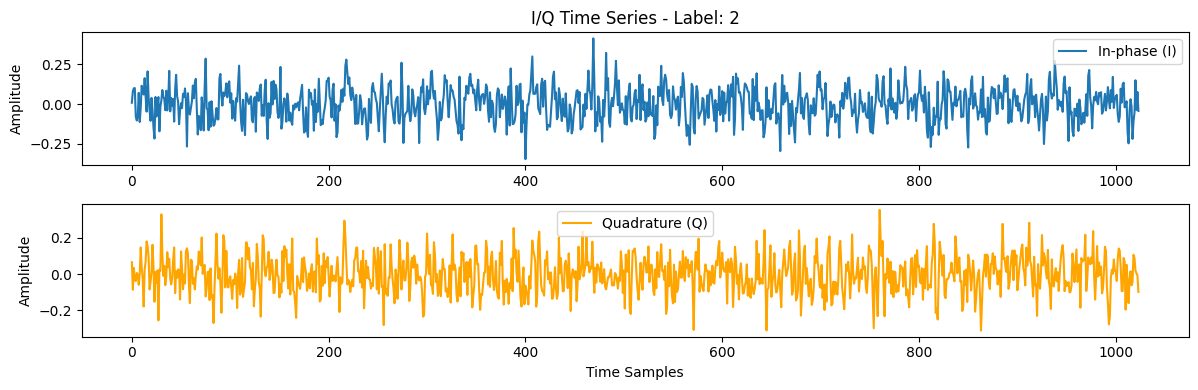

In [6]:
import matplotlib.pyplot as plt

# Grab one example from the dataset
sample_iq, sample_label = dataset[0]  # shape: [2, 1024]
I = sample_iq[0].numpy()
Q = sample_iq[1].numpy()

# Plot I and Q signals
plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
plt.plot(I, label='In-phase (I)')
plt.title(f'I/Q Time Series - Label: {sample_label.item()}')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Q, label='Quadrature (Q)', color='orange')
plt.xlabel('Time Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


## 🧠 Interpretation:

-> The horizontal bands reflect the frequency components across time.

-> Even with noise, some structure is visible → which deep learning models can latch onto.

This format is now CNN-ready ✅
Here we have three ways of approaching this problem 

-> CNN (on spectrograms) — good for time-frequency patterns

-> LSTM (on I/Q time series) — good for temporal memory

-> Hybrid CNN + LSTM — best of both worlds (CNN for feature extraction → LSTM for temporal context)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17796\3515842964.py:12: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(complex_signal, nperseg=128)


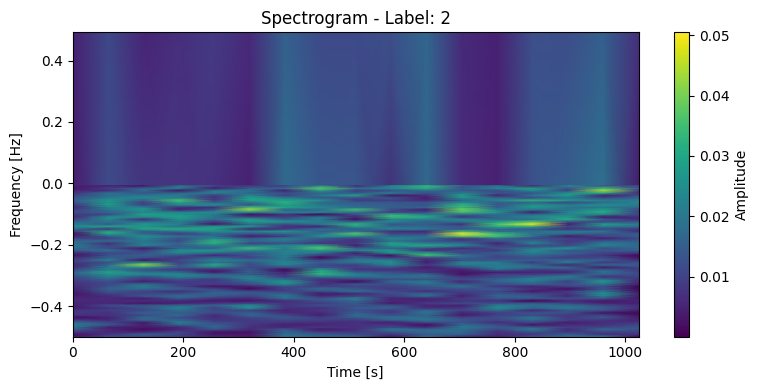

In [7]:
from scipy.signal import stft

# Use one I/Q segment again
segment = dataset[0][0].numpy()  # shape: [2, 1024]
I = segment[0]
Q = segment[1]

# Combine into complex signal
complex_signal = I + 1j * Q

# Apply Short-Time Fourier Transform
f, t, Zxx = stft(complex_signal, nperseg=128)

# Get magnitude (in dB) for visualization
spectrogram = np.abs(Zxx)

# Plot it
plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, spectrogram, shading='gouraud')
plt.title(f'Spectrogram - Label: {dataset[0][1].item()}')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


In [8]:
from scipy.signal import stft

class OFDMSpectrogramDataset(Dataset):
    def __init__(self, root_dir, segment_length=1024, nperseg=128):
        self.samples = []
        self.segment_length = segment_length
        self.nperseg = nperseg
        self.label_map = MOD_LABELS

        for mod_class in os.listdir(root_dir):
            class_path = os.path.join(root_dir, mod_class)
            if not os.path.isdir(class_path):
                continue

            label = self.label_map.get(mod_class)
            if label is None:
                continue

            for file in os.listdir(class_path):
                if file.endswith('.h5'):
                    file_path = os.path.join(class_path, file)
                    try:
                        with h5py.File(file_path, 'r') as f:
                            key = list(f.keys())[0]
                            signal = np.array(f[key]).squeeze()

                            num_segments = len(signal) // segment_length
                            for i in range(num_segments):
                                start = i * segment_length
                                segment = signal[start:start+segment_length]
                                self.samples.append((segment, label))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        segment, label = self.samples[idx]
        signal = segment.astype(np.complex64)

        # STFT to spectrogram
        f, t, Zxx = stft(signal, nperseg=self.nperseg)
        spectrogram = np.abs(Zxx).astype(np.float32)  # shape: [freq, time]

        # Normalize
        spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram) + 1e-8)

        return torch.tensor(spectrogram).unsqueeze(0), torch.tensor(label)  # [1, F, T]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = None  # will be set after a forward pass

        self.fc1 = None  # placeholder
        self.fc2 = nn.Linear(128, num_classes)  # second FC is fixed

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 16, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 32, H/4, W/4]
        x = self.pool(F.relu(self.conv3(x)))  # → [B, 64, H/8, W/8]

        # Dynamically calculate flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 128)
            self.fc1.to(x.device)

        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               # Now safe
        x = self.fc2(x)
        return x



In [10]:
from torch.utils.data import DataLoader, random_split

# Load full dataset
full_dataset = OFDMSpectrogramDataset("D:/SingalProject/OFDM Modulation Classification Dataset (1)")

# Split into train (80%) and val (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectrogramCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        print(f"Epoch {epoch+1}: "
              f"Train Acc = {train_correct/len(train_loader.dataset):.4f}, "
              f"Val Acc = {val_correct/val_total:.4f}")


In [17]:
train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 - Training:   0%|                                                                                | 0/4916 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_8728\1314719809.py:43: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(signal, nperseg=self.nperseg)
Epoch 1/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:25<00:00, 33.77it/s]


Epoch 1: Train Acc = 0.5988, Val Acc = 0.7283


Epoch 2/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:36<00:00, 31.37it/s]


Epoch 2: Train Acc = 0.7786, Val Acc = 0.8043


Epoch 3/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:40<00:00, 30.61it/s]


Epoch 3: Train Acc = 0.8090, Val Acc = 0.8188


Epoch 4/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:22<00:00, 34.40it/s]


Epoch 4: Train Acc = 0.8218, Val Acc = 0.8224


Epoch 5/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:09<00:00, 37.90it/s]


Epoch 5: Train Acc = 0.8288, Val Acc = 0.8283


Epoch 6/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:08<00:00, 38.33it/s]


Epoch 6: Train Acc = 0.8341, Val Acc = 0.8328


Epoch 7/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:13<00:00, 36.74it/s]


Epoch 7: Train Acc = 0.8382, Val Acc = 0.8311


Epoch 8/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:31<00:00, 32.41it/s]


Epoch 8: Train Acc = 0.8409, Val Acc = 0.8358


Epoch 9/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:31<00:00, 32.54it/s]


Epoch 9: Train Acc = 0.8437, Val Acc = 0.8352


Epoch 10/10 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [02:26<00:00, 33.62it/s]


Epoch 10: Train Acc = 0.8463, Val Acc = 0.8362


In [18]:
torch.save(model.state_dict(), "spectrogram_cnn.pth")


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SpectrogramCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.flattened_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 128).to(x.device)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10 - Training:   0%|                                                                                | 0/4916 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_8728\1314719809.py:43: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(signal, nperseg=self.nperseg)
Epoch 1/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:18<00:00, 35.39it/s]


Epoch 1: Train Acc = 0.8475, Val Acc = 0.8412


Epoch 2/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:13<00:00, 36.82it/s]


Epoch 2: Train Acc = 0.8494, Val Acc = 0.8396


Epoch 3/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:15<00:00, 36.19it/s]


Epoch 3: Train Acc = 0.8507, Val Acc = 0.8406


Epoch 4/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:38<00:00, 31.02it/s]


Epoch 4: Train Acc = 0.8518, Val Acc = 0.8438


Epoch 5/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:28<00:00, 33.00it/s]


Epoch 5: Train Acc = 0.8531, Val Acc = 0.8438


Epoch 6/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:09<00:00, 37.90it/s]


Epoch 6: Train Acc = 0.8540, Val Acc = 0.8430


Epoch 7/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:21<00:00, 34.80it/s]


Epoch 7: Train Acc = 0.8548, Val Acc = 0.8427


Epoch 8/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:14<00:00, 66.02it/s]


Epoch 8: Train Acc = 0.8558, Val Acc = 0.8416


Epoch 9/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 84.63it/s]


Epoch 9: Train Acc = 0.8565, Val Acc = 0.8412


Epoch 10/10 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:53<00:00, 91.23it/s]


Epoch 10: Train Acc = 0.8577, Val Acc = 0.8438


In [22]:
torch.save(model.state_dict(), "spectrogram_cnn_bn_dropout.pth")


In [14]:
class OFDMIQSequenceDataset(Dataset):
    def __init__(self, root_dir, segment_length=1024):
        self.samples = []
        self.segment_length = segment_length
        self.label_map = MOD_LABELS

        for mod_class in os.listdir(root_dir):
            class_path = os.path.join(root_dir, mod_class)
            if not os.path.isdir(class_path):
                continue

            label = self.label_map.get(mod_class)
            if label is None:
                continue

            for file in os.listdir(class_path):
                if file.endswith('.h5'):
                    file_path = os.path.join(class_path, file)
                    try:
                        with h5py.File(file_path, 'r') as f:
                            key = list(f.keys())[0]
                            signal = np.array(f[key]).squeeze()

                            num_segments = len(signal) // segment_length
                            for i in range(num_segments):
                                start = i * segment_length
                                segment = signal[start:start+segment_length]
                                self.samples.append((segment, label))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        segment, label = self.samples[idx]
        I = segment.real
        Q = segment.imag
        iq_sequence = np.stack([I, Q], axis=1)  # [1024, 2]
        return torch.tensor(iq_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, num_classes=6):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: [B, 1024, 2]
        out, _ = self.lstm(x)  # out: [B, 1024, hidden*2]
        out = out[:, -1, :]    # Take output from last time step: [B, hidden*2]
        out = self.fc(out)     # [B, num_classes]
        return out


In [16]:
# Load dataset
iq_dataset = OFDMIQSequenceDataset("D:/SingalProject/OFDM Modulation Classification Dataset (1)")
train_size = int(0.8 * len(iq_dataset))
val_size = len(iq_dataset) - train_size
train_dataset, val_dataset = random_split(iq_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_correct = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        print(f"Epoch {epoch+1}: Train Acc = {train_correct/len(train_loader.dataset):.4f}, "
              f"Val Acc = {val_correct/val_total:.4f}")


In [27]:
train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:38<00:00, 49.79it/s]


Epoch 1: Train Acc = 0.1747, Val Acc = 0.1815


Epoch 2/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:42<00:00, 47.92it/s]


Epoch 2: Train Acc = 0.1754, Val Acc = 0.1653


Epoch 3/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:36<00:00, 50.95it/s]


Epoch 3: Train Acc = 0.1682, Val Acc = 0.1718


Epoch 4/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:38<00:00, 49.81it/s]


Epoch 4: Train Acc = 0.1705, Val Acc = 0.1672


Epoch 5/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:35<00:00, 51.45it/s]


Epoch 5: Train Acc = 0.1733, Val Acc = 0.1781


Epoch 6/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:35<00:00, 51.36it/s]


Epoch 6: Train Acc = 0.2151, Val Acc = 0.2866


Epoch 7/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:35<00:00, 51.48it/s]


Epoch 7: Train Acc = 0.4577, Val Acc = 0.6503


Epoch 8/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:35<00:00, 51.52it/s]


Epoch 8: Train Acc = 0.6447, Val Acc = 0.6838


Epoch 9/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:35<00:00, 51.40it/s]


Epoch 9: Train Acc = 0.6281, Val Acc = 0.6883


Epoch 10/10 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:39<00:00, 49.39it/s]


Epoch 10: Train Acc = 0.6936, Val Acc = 0.7156


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedLSTMClassifier(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=3, num_classes=6, dropout=0.3):
        super(ImprovedLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [19]:
class OFDMIQWithMagPhaseDataset(Dataset):
    def __init__(self, root_dir, segment_length=1024):
        self.samples = []
        self.segment_length = segment_length
        self.label_map = MOD_LABELS

        for mod_class in os.listdir(root_dir):
            class_path = os.path.join(root_dir, mod_class)
            if not os.path.isdir(class_path):
                continue

            label = self.label_map.get(mod_class)
            if label is None:
                continue

            for file in os.listdir(class_path):
                if file.endswith('.h5'):
                    file_path = os.path.join(class_path, file)
                    try:
                        with h5py.File(file_path, 'r') as f:
                            key = list(f.keys())[0]
                            signal = np.array(f[key]).squeeze()

                            num_segments = len(signal) // segment_length
                            for i in range(num_segments):
                                start = i * segment_length
                                segment = signal[start:start+segment_length]
                                self.samples.append((segment, label))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        segment, label = self.samples[idx]
        I = segment.real
        Q = segment.imag
        mag = np.abs(segment)
        phase = np.angle(segment)
        features = np.stack([I, Q, mag, phase], axis=1)  # shape [1024, 4]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [20]:
class OFDMIQWithMagPhaseDataset(Dataset):
    def __init__(self, root_dir, segment_length=1024):
        self.samples = []
        self.segment_length = segment_length
        self.label_map = MOD_LABELS

        for mod_class in os.listdir(root_dir):
            class_path = os.path.join(root_dir, mod_class)
            if not os.path.isdir(class_path):
                continue

            label = self.label_map.get(mod_class)
            if label is None:
                continue

            for file in os.listdir(class_path):
                if file.endswith('.h5'):
                    file_path = os.path.join(class_path, file)
                    try:
                        with h5py.File(file_path, 'r') as f:
                            key = list(f.keys())[0]
                            signal = np.array(f[key]).squeeze()

                            num_segments = len(signal) // segment_length
                            for i in range(num_segments):
                                start = i * segment_length
                                segment = signal[start:start+segment_length]
                                self.samples.append((segment, label))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        segment, label = self.samples[idx]
        I = segment.real
        Q = segment.imag
        mag = np.abs(segment)
        phase = np.angle(segment)
        features = np.stack([I, Q, mag, phase], axis=1)  # shape [1024, 4]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [21]:
model = ImprovedLSTMClassifier().to(device)
dataset = OFDMIQWithMagPhaseDataset("D:/SingalProject/OFDM Modulation Classification Dataset (1)")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [22]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_correct = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_correct += (outputs.argmax(1) == labels).sum().item()

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        scheduler.step()

        print(f"Epoch {epoch+1}: Train Acc = {train_correct/len(train_loader.dataset):.4f}, "
              f"Val Acc = {val_correct/val_total:.4f}")


In [26]:
train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [10:05<00:00,  8.11it/s]


Epoch 1: Train Acc = 0.1779, Val Acc = 0.1733


Epoch 2/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [09:31<00:00,  8.61it/s]


Epoch 2: Train Acc = 0.1747, Val Acc = 0.1671


Epoch 3/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [09:33<00:00,  8.58it/s]


Epoch 3: Train Acc = 0.1674, Val Acc = 0.1651


Epoch 4/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [10:02<00:00,  8.16it/s]


Epoch 4: Train Acc = 0.2454, Val Acc = 0.4883


Epoch 5/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [10:17<00:00,  7.97it/s]


Epoch 5: Train Acc = 0.5782, Val Acc = 0.6561


Epoch 6/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [09:49<00:00,  8.34it/s]


Epoch 6: Train Acc = 0.5886, Val Acc = 0.6664


Epoch 7/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [09:29<00:00,  8.64it/s]


Epoch 7: Train Acc = 0.6670, Val Acc = 0.6928


Epoch 8/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [09:44<00:00,  8.41it/s]


Epoch 8: Train Acc = 0.6996, Val Acc = 0.7180


Epoch 9/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [10:02<00:00,  8.16it/s]


Epoch 9: Train Acc = 0.7262, Val Acc = 0.7420


Epoch 10/10 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [09:53<00:00,  8.28it/s]


Epoch 10: Train Acc = 0.7478, Val Acc = 0.7535


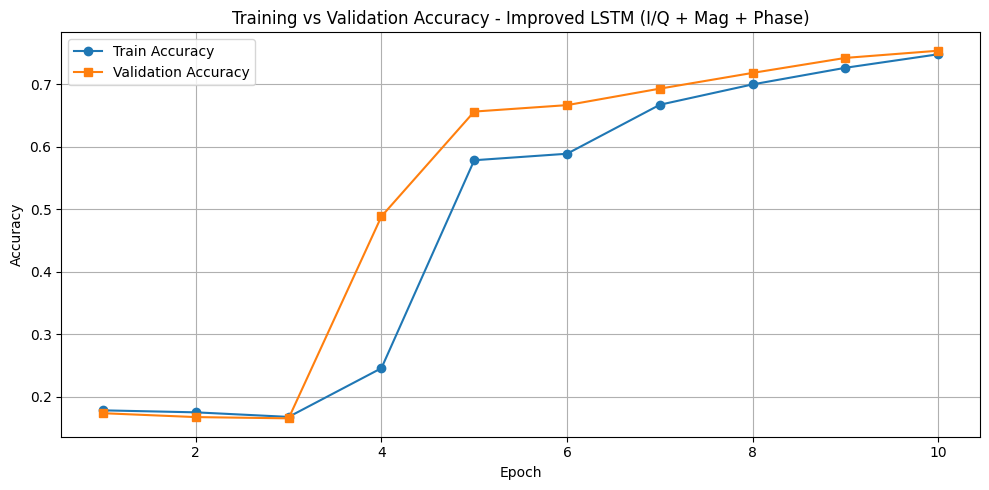

In [27]:
import matplotlib.pyplot as plt

# Accuracy values from the improved LSTM run
epochs = list(range(1, 11))
train_acc = [0.1779, 0.1747, 0.1674, 0.2454, 0.5782, 0.5886, 0.6670, 0.6996, 0.7262, 0.7478]
val_acc =   [0.1733, 0.1671, 0.1651, 0.4883, 0.6561, 0.6664, 0.6928, 0.7180, 0.7420, 0.7535]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='s', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy - Improved LSTM (I/Q + Mag + Phase)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridCNNLSTM(nn.Module):
    def __init__(self, num_classes=6, lstm_hidden=128, lstm_layers=2):
        super(HybridCNNLSTM, self).__init__()

        # CNN feature extractor
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Placeholder for reshaped dimensions
        self.flattened = None

        # LSTM for temporal modeling
        self.lstm_hidden = lstm_hidden
        self.lstm = nn.LSTM(input_size=32, hidden_size=lstm_hidden,
                            num_layers=lstm_layers, batch_first=True, bidirectional=True)

        # Final classification layer
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, x):
        # x: [B, 1, F, T]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 16, F/2, T/2]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B, 32, F/4, T/4]
        x = self.dropout(x)

        # Reshape for LSTM: [B, T', Features]
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2)         # [B, T, C, F]
        x = x.mean(dim=-1)               # [B, T, C] → average over freq dimension
# now input_size = C = 32
   # [B, T, Features]

        # LSTM
        x, _ = self.lstm(x)        # [B, T, H*2]
        x = x[:, -1, :]            # Take last time step
        x = self.fc(x)
        return x


In [24]:
model = HybridCNNLSTM(num_classes=6).to(device)
dataset = OFDMSpectrogramDataset("D:/SingalProject/OFDM Modulation Classification Dataset (1)")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [33]:
train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 - Training:   0%|                                                                                | 0/4916 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_25624\1314719809.py:43: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(signal, nperseg=self.nperseg)
Epoch 1/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:20<00:00, 35.04it/s]


Epoch 1: Train Acc = 0.6309, Val Acc = 0.7773


Epoch 2/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:17<00:00, 35.70it/s]


Epoch 2: Train Acc = 0.7739, Val Acc = 0.7221


Epoch 3/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:17<00:00, 35.69it/s]


Epoch 3: Train Acc = 0.7935, Val Acc = 0.7315


Epoch 4/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:18<00:00, 35.43it/s]


Epoch 4: Train Acc = 0.8046, Val Acc = 0.8019


Epoch 5/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:22<00:00, 34.39it/s]


Epoch 5: Train Acc = 0.8121, Val Acc = 0.8307


Epoch 6/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:19<00:00, 35.20it/s]


Epoch 6: Train Acc = 0.8171, Val Acc = 0.8315


Epoch 7/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:22<00:00, 34.39it/s]


Epoch 7: Train Acc = 0.8215, Val Acc = 0.8365


Epoch 8/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:31<00:00, 32.36it/s]


Epoch 8: Train Acc = 0.8259, Val Acc = 0.8348


Epoch 9/10 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [02:40<00:00, 30.56it/s]


Epoch 9: Train Acc = 0.8289, Val Acc = 0.8376


Epoch 10/10 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [02:34<00:00, 31.73it/s]


Epoch 10: Train Acc = 0.8314, Val Acc = 0.8429


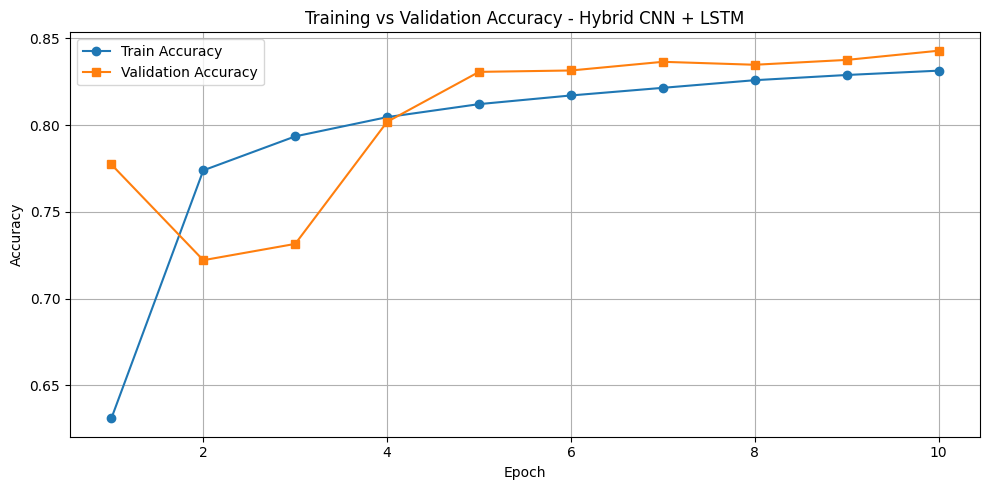

In [1]:
import matplotlib.pyplot as plt

# Accuracy values from Hybrid CNN+LSTM training
epochs = list(range(1, 11))
train_acc = [0.6309, 0.7739, 0.7935, 0.8046, 0.8121, 0.8171, 0.8215, 0.8259, 0.8289, 0.8314]
val_acc =   [0.7773, 0.7221, 0.7315, 0.8019, 0.8307, 0.8315, 0.8365, 0.8348, 0.8376, 0.8429]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='s', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy - Hybrid CNN + LSTM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
train_model(model, train_loader, val_loader, epochs=30)

Epoch 1/30 - Training:   0%|                                                                                | 0/4916 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_17796\1314719809.py:43: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(signal, nperseg=self.nperseg)
Epoch 1/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:03<00:00, 77.91it/s]
D:\SingalProject\signalpytorch\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1: Train Acc = 0.6431, Val Acc = 0.7508


Epoch 2/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:57<00:00, 85.82it/s]


Epoch 2: Train Acc = 0.7800, Val Acc = 0.8081


Epoch 3/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:57<00:00, 85.12it/s]


Epoch 3: Train Acc = 0.7985, Val Acc = 0.7833


Epoch 4/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 82.12it/s]


Epoch 4: Train Acc = 0.8083, Val Acc = 0.8230


Epoch 5/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 83.82it/s]


Epoch 5: Train Acc = 0.8156, Val Acc = 0.8260


Epoch 6/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 83.66it/s]


Epoch 6: Train Acc = 0.8206, Val Acc = 0.8321


Epoch 7/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:57<00:00, 85.60it/s]


Epoch 7: Train Acc = 0.8253, Val Acc = 0.8257


Epoch 8/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [01:00<00:00, 81.72it/s]


Epoch 8: Train Acc = 0.8288, Val Acc = 0.8234


Epoch 9/30 - Training: 100%|█████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 83.22it/s]


Epoch 9: Train Acc = 0.8331, Val Acc = 0.8460


Epoch 10/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:01<00:00, 80.34it/s]


Epoch 10: Train Acc = 0.8358, Val Acc = 0.8418


Epoch 11/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:00<00:00, 81.20it/s]


Epoch 11: Train Acc = 0.8382, Val Acc = 0.8132


Epoch 12/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 83.54it/s]


Epoch 12: Train Acc = 0.8403, Val Acc = 0.8436


Epoch 13/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:00<00:00, 81.06it/s]


Epoch 13: Train Acc = 0.8417, Val Acc = 0.8441


Epoch 14/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:01<00:00, 80.41it/s]


Epoch 14: Train Acc = 0.8439, Val Acc = 0.8299


Epoch 15/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:01<00:00, 79.67it/s]


Epoch 15: Train Acc = 0.8445, Val Acc = 0.8540


Epoch 16/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 83.51it/s]


Epoch 16: Train Acc = 0.8464, Val Acc = 0.8441


Epoch 17/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 83.13it/s]


Epoch 17: Train Acc = 0.8477, Val Acc = 0.8517


Epoch 18/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:00<00:00, 81.64it/s]


Epoch 18: Train Acc = 0.8486, Val Acc = 0.8500


Epoch 19/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 82.07it/s]


Epoch 19: Train Acc = 0.8499, Val Acc = 0.8574


Epoch 20/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 82.36it/s]


Epoch 20: Train Acc = 0.8510, Val Acc = 0.8535


Epoch 21/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 81.99it/s]


Epoch 21: Train Acc = 0.8522, Val Acc = 0.8559


Epoch 22/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 83.08it/s]


Epoch 22: Train Acc = 0.8530, Val Acc = 0.8546


Epoch 23/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:00<00:00, 81.36it/s]


Epoch 23: Train Acc = 0.8534, Val Acc = 0.8559


Epoch 24/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 84.45it/s]


Epoch 24: Train Acc = 0.8549, Val Acc = 0.8574


Epoch 25/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [01:00<00:00, 81.57it/s]


Epoch 25: Train Acc = 0.8551, Val Acc = 0.8529


Epoch 26/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 83.13it/s]


Epoch 26: Train Acc = 0.8562, Val Acc = 0.8574


Epoch 27/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:58<00:00, 83.84it/s]


Epoch 27: Train Acc = 0.8577, Val Acc = 0.8584


Epoch 28/30 - Training: 100%|████████████████████████████████████████████████████████████████████| 4916/4916 [00:59<00:00, 82.43it/s]
